In [212]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve,RandomizedSearchCV,RepeatedStratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import (classification_report,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, auc,
    matthews_corrcoef, balanced_accuracy_score,
    roc_curve, precision_recall_curve, make_scorer,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay)
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils import resample
import time
import re
import shap

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger("phik").setLevel(logging.ERROR)

# Modelado e Interpretación

In [213]:
df = pd.read_csv('../data/processed.csv')
features = df.columns.drop('Survived')
df.head()

,Age,Pclass_2,Pclass_3,Sex_male,CabinKnown,FareAboveMedian,Embarked_Q,Embarked_S,IsAlone,Survived
0,22,0,1,1,0,0,0,1,0,0
1,38,0,0,0,1,1,0,0,0,1
2,26,0,1,0,0,0,0,1,1,1
3,35,0,0,0,1,1,0,1,0,1
4,35,0,1,1,0,0,0,1,1,0


In [214]:
Y = df["Survived"]
X = df.drop(columns=["Survived"])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## XGBoost

Hallamos los mejores hiperparámetros:

In [215]:
learning_rate = [0.01, 0.05, 0.1, 0.3]
n_estimators = [100, 200, 300]
max_depth = [3, 5, 7]
subsample = [0.7, 0.8, 0.9, 1.0]
colsample_bytree = [0.7, 0.8, 0.9, 1.0]
gamma = [0, 0.1, 0.3, 0.5]
# def hyperparametros(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, gamma):
#     best_accuracy = 0
#     for lr in learning_rate:
#         for n in n_estimators:
#             for md in max_depth:
#                 for s in subsample:
#                     for cs in colsample_bytree:
#                         for g in gamma:
#                             model = XGBClassifier(
#                                 learning_rate=lr,
#                                 n_estimators=n,
#                                 max_depth=md,
#                                 subsample=s,
#                                 colsample_bytree=cs,
#                                 gamma=g)
#                             model.fit(X_train, Y_train)
#                             y_pred = model.predict(X_test)
#                             accuracy = accuracy_score(Y_test, y_pred)
#                             if accuracy > best_accuracy:
#                                 best_accuracy = accuracy
#                                 best_params = [lr, n, md, s, cs, g]
#     return best_accuracy, best_params

# print(hyperparametros(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, gamma))

Entrenamiento:

Accuracy: 0.8156424581005587

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.80      0.91      0.85       105
           1       0.85      0.68      0.75        74

    accuracy                           0.82       179
   macro avg       0.82      0.79      0.80       179
weighted avg       0.82      0.82      0.81       179



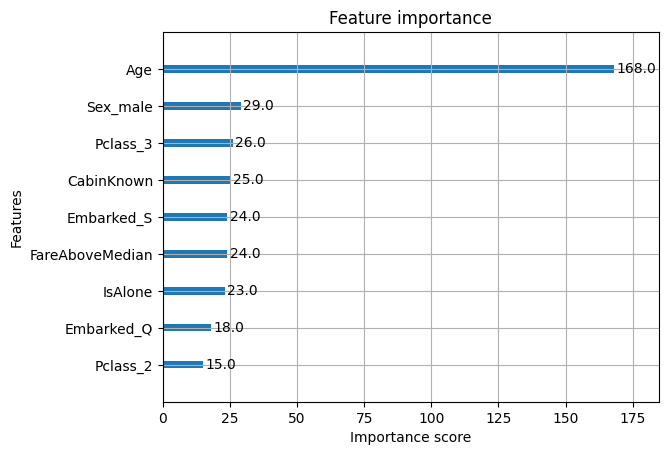

In [216]:
b_p = [0.3, 100, 3, 0.9, 0.7, 0.1]

model = XGBClassifier(
    n_estimators=b_p[1],
    learning_rate=b_p[0],
    max_depth=b_p[2],
    subsample=b_p[3],
    colsample_bytree=b_p[4],
    gamma=b_p[5],
    early_stopping_rounds=50,
    random_state=42)

start_train = time.time()
model.fit(X_train, Y_train,
    eval_set=[(X_train, Y_train), (X_test, Y_test)],
    verbose=False)
end_train = time.time()

evals_result = model.evals_result()

start_infer = time.time()
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1] 
end_infer = time.time()

AUC = []
fpr, tpr, thresholds = roc_curve(Y_test, y_proba)
roc_auc = ((fpr,tpr) , auc(fpr, tpr))
AUC.append(roc_auc)

print("Accuracy:", accuracy_score(Y_test, y_pred))
print("\nReporte de Clasificación:\n", classification_report(Y_test, y_pred))

plot_importance(model)
plt.show()

Métricas de Evaluación:

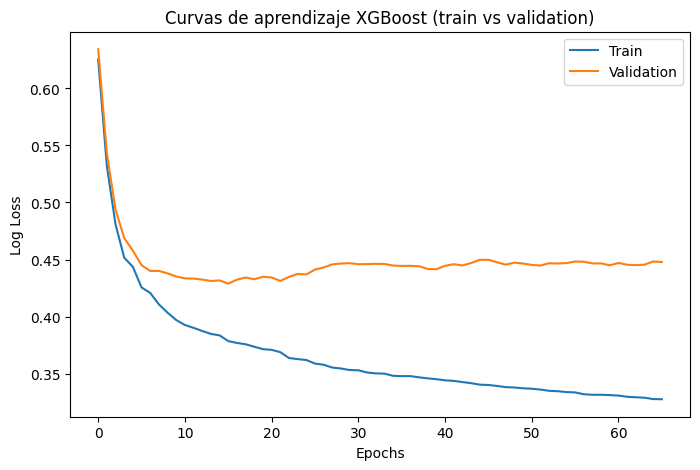

<Figure size 600x400 with 0 Axes>

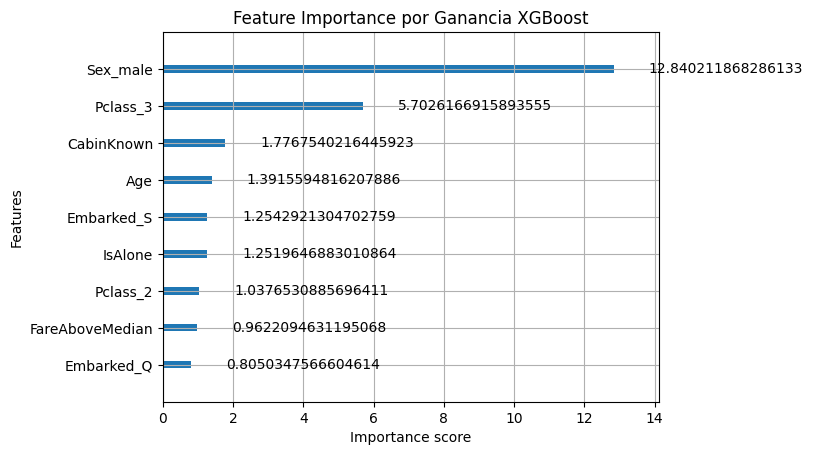

Best iteration: 15
Best score (logloss): 0.42886200992588225


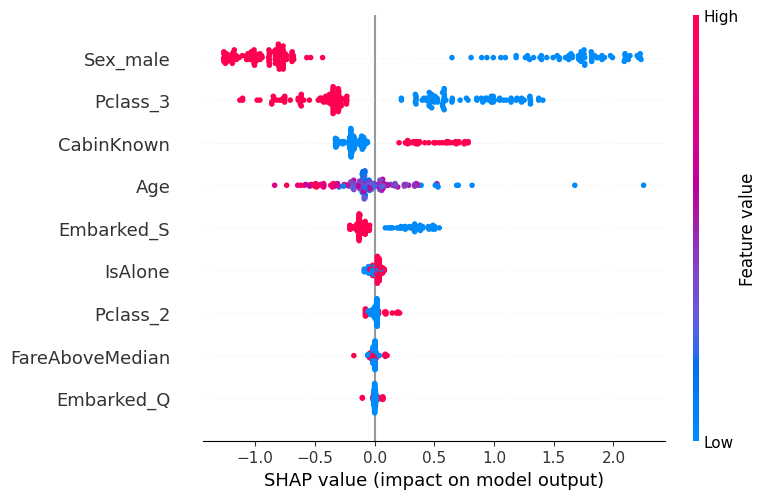

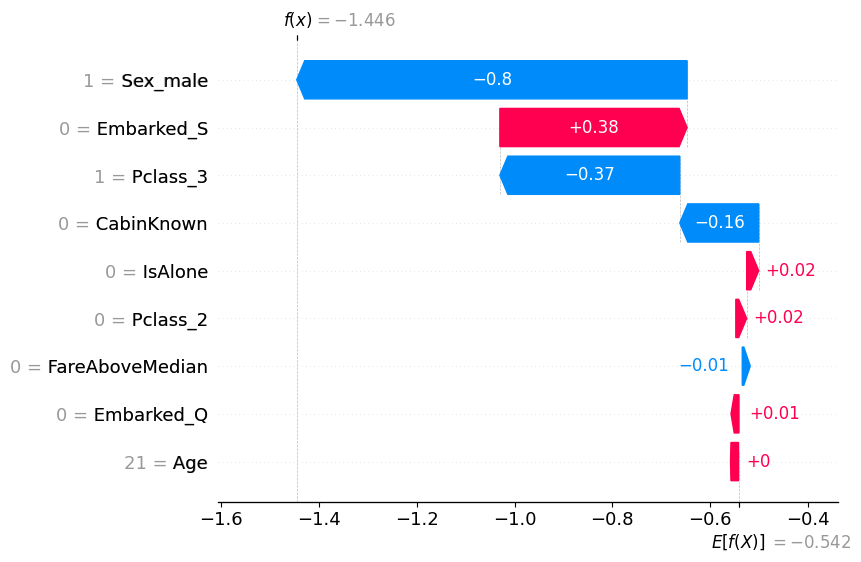

In [217]:
# 1. Curvas de aprendizaje
epochs = len(evals_result["validation_0"]["logloss"])
x_axis = range(0, epochs)

plt.figure(figsize=(8, 5))
plt.plot(x_axis, evals_result["validation_0"]["logloss"], label="Train")
plt.plot(x_axis, evals_result["validation_1"]["logloss"], label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.title("Curvas de aprendizaje XGBoost (train vs validation)")
plt.legend()
plt.show()

# 2. Importancia de variables por GANANCIA
plt.figure(figsize=(6, 4))
plot_importance(model, importance_type="gain")
plt.title("Feature Importance por Ganancia XGBoost")
plt.show()

# 3. Resultados con early stopping
print(f"Best iteration: {model.best_iteration}")
print(f"Best score (logloss): {model.best_score}")

# 4. Interpretación con SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)
# waterfall
shap.plots.waterfall(shap_values[0])  # Explicación para la primera predicción

### Evaulación y Comparación

In [218]:
# Métricas básicas
accuracy  = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall    = recall_score(Y_test, y_pred)
f1        = f1_score(Y_test, y_pred)

roc_auc   = roc_auc_score(Y_test, y_proba)
pr_auc    = average_precision_score(Y_test, y_proba)
mcc       = matthews_corrcoef(Y_test, y_pred)
bal_acc   = balanced_accuracy_score(Y_test, y_pred)

metrics = {
    "Modelo": "XGBoost",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1": f1,
    "ROC-AUC": roc_auc,
    "Tiempo Training": end_train - start_train,
    "Tiempo Inference": end_infer - start_infer
}

df_metrics = pd.DataFrame([metrics])

print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-Score:  {f1:.3f}")
print(f"ROC-AUC:   {roc_auc:.3f}")
print(f"PR-AUC:    {pr_auc:.3f}")
print(f"MCC:       {mcc:.3f}")
print(f"Balanced Accuracy: {bal_acc:.3f}")

Accuracy:  0.816
Precision: 0.847
Recall:    0.676
F1-Score:  0.752
ROC-AUC:   0.880
PR-AUC:    0.860
MCC:       0.618
Balanced Accuracy: 0.795


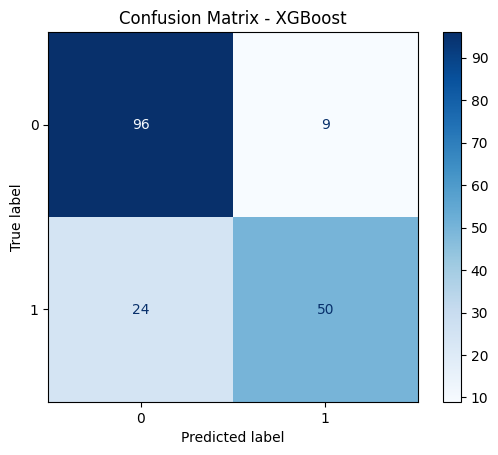

In [219]:
cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.show()

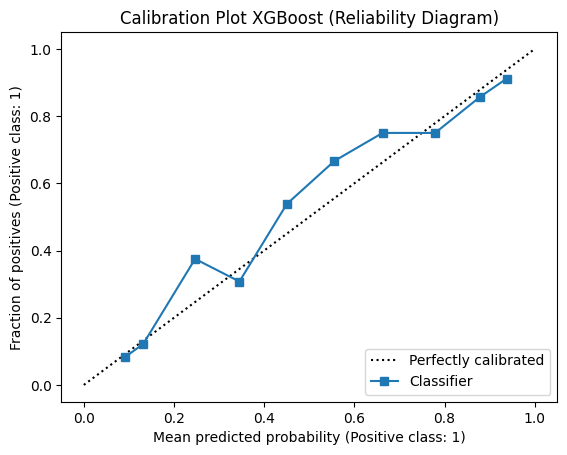

Brier Score: 0.134712484556658
Expected Calibration Error (ECE): 0.03231364338757605


In [220]:
disp = CalibrationDisplay.from_predictions(
    Y_test, y_proba, n_bins=10, strategy="uniform")
plt.title("Calibration Plot XGBoost (Reliability Diagram)")
plt.show()

from sklearn.metrics import brier_score_loss

brier = brier_score_loss(Y_test, y_proba)
print("Brier Score:", brier)

def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins+1)
    binids = np.digitize(y_prob, bins) - 1

    ece = 0.0
    for i in range(n_bins):
        mask = binids == i
        if np.any(mask):
            avg_conf = y_prob[mask].mean()
            avg_acc  = y_true[mask].mean()
            ece += np.abs(avg_conf - avg_acc) * len(y_prob[mask]) / len(y_prob)
    return ece

ece = expected_calibration_error(Y_test.values, y_proba, n_bins=10)
print("Expected Calibration Error (ECE):", ece)

## Regresión Logística

Hallamos los mejores hiperparámetros:

In [221]:
C = [0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2', 'elasticnet']
solver = ['liblinear', 'saga'] #para l1
class_weight = [None, 'balanced']

# def hyperparametros(C, penalty, solver, class_weight):
#     best_accuracy = 0
#     for c in C:
#         for p in penalty:
#             if p == 'l1':
#                 for s in solver:
#                     for cw in class_weight:
#                         try:
#                             model = LogisticRegression(
#                                 C=c,
#                                 penalty=p,
#                                 solver=s,
#                                 class_weight=cw,
#                                 max_iter=1000,
#                                 random_state=42)
#                             model.fit(X_train, Y_train)
#                             y_pred = model.predict(X_test)
#                             accuracy = accuracy_score(Y_test, y_pred)
#                             #print(accuracy)
#                             if accuracy > best_accuracy:
#                                 best_accuracy = accuracy
#                                 best_params = [c, p, s, cw]
#                         except:
#                             continue
#             else:
#                 for cw in class_weight:
#                     try:
#                         model = LogisticRegression(
#                             C=c,
#                             penalty=p,
#                             solver=s,
#                             class_weight=cw,
#                             max_iter=1000,
#                             random_state=42)
#                         model.fit(X_train, Y_train)
#                         y_pred = model.predict(X_test)
#                         accuracy = accuracy_score(Y_test, y_pred)
#                         #print(accuracy)
#                         if accuracy > best_accuracy:
#                             best_accuracy = accuracy
#                             best_params = [c, p, s, cw]
#                     except:
#                         continue
#     return best_accuracy, best_params

# print(hyperparametros(C, penalty, solver, class_weight))

In [222]:
b_p = [0.1, 'l1', 'liblinear', 'balanced']

model = LogisticRegression(
    C=b_p[0],
    penalty=b_p[1],
    solver=b_p[2],
    class_weight=b_p[3],
    random_state=42)

start_train = time.time()
model.fit(X_train, Y_train)
end_train = time.time()

start_infer = time.time()
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1] 
end_infer = time.time()

fpr, tpr, thresholds = roc_curve(Y_test, y_proba)
roc_auc = ((fpr,tpr) , auc(fpr, tpr))
AUC.append(roc_auc)

print("Accuracy:", accuracy_score(Y_test, y_pred))
print("\nReporte de Clasificación:\n", classification_report(Y_test, y_pred))

Accuracy: 0.7988826815642458

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82       105
           1       0.73      0.82      0.77        74

    accuracy                           0.80       179
   macro avg       0.79      0.80      0.80       179
weighted avg       0.81      0.80      0.80       179



Coeficientes del modelo:

In [223]:
coef = pd.DataFrame({
    "Variable": features,
    "Coef": model.coef_[0],
    "Exp(Coef)": np.exp(model.coef_[0])  # Odds ratio
}).sort_values(by="Coef", ascending=False)

print(coef)

          Variable      Coef  Exp(Coef)
4       CabinKnown  0.932889   2.541842
1         Pclass_2  0.058594   1.060345
7       Embarked_S  0.000000   1.000000
6       Embarked_Q  0.000000   1.000000
5  FareAboveMedian  0.000000   1.000000
8          IsAlone  0.000000   1.000000
0              Age -0.003983   0.996025
2         Pclass_3 -0.413046   0.661632
3         Sex_male -1.912558   0.147702


El valor exp(coef) (odds ratio):
- \>1 → aumenta la probabilidad de sobrevivir.
- <1 → reduce la probabilidad de sobrevivir.
- ≈1 → casi no afecta.

Entonces las variables más importantes son 'CabinKnown', 'Pclass_3' y 'Sex_male'.

Curvas de regularización:

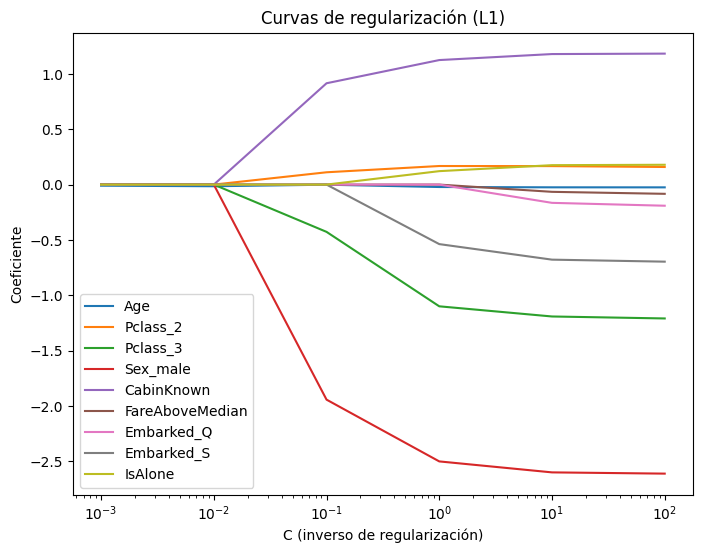

In [224]:
coefs = []
for c in C:
    model = LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000, C=c, class_weight=None, random_state=42)
    model.fit(X_train, Y_train)
    coefs.append(model.coef_[0])
    
coefs = np.array(coefs)

plt.figure(figsize=(8,6))
for i, feature in enumerate(features):
    plt.plot(C, coefs[:, i], label=feature)

plt.xscale("log")
plt.xlabel("C (inverso de regularización)")
plt.ylabel("Coeficiente")
plt.title("Curvas de regularización (L1)")
plt.legend()
plt.show()

Verificación de supuestos (linealidad en log-odds):

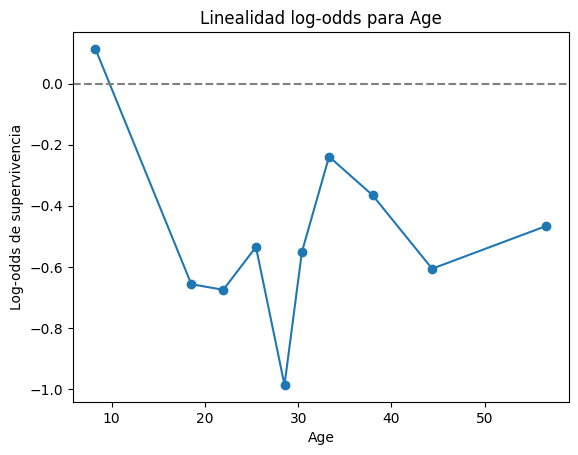

In [225]:
def check_linearity_logodds(df, feature, target, bins=10):
    df = df[[feature, target]].dropna()
    df['bin'] = pd.qcut(df[feature], q=bins, duplicates='drop')
    
    grouped = df.groupby('bin').agg(
        mean_feature=(feature, 'mean'),
        mean_target=(target, 'mean')
    ).reset_index()
    
    grouped['log_odds'] = np.log(grouped['mean_target'] / (1 - grouped['mean_target']))
    
    plt.plot(grouped['mean_feature'], grouped['log_odds'], marker='o')
    plt.xlabel(feature)
    plt.ylabel("Log-odds de supervivencia")
    plt.title(f"Linealidad log-odds para {feature}")
    plt.axhline(0, color='gray', linestyle='--')
    plt.show()

check_linearity_logodds(df, "Age", "Survived")

### Evaulación y Comparación

In [226]:
# Métricas básicas
accuracy  = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall    = recall_score(Y_test, y_pred)
f1        = f1_score(Y_test, y_pred)

roc_auc   = roc_auc_score(Y_test, y_proba)
pr_auc    = average_precision_score(Y_test, y_proba)
mcc       = matthews_corrcoef(Y_test, y_pred)
bal_acc   = balanced_accuracy_score(Y_test, y_pred)

metrics = {
    "Modelo": "Regresión Logística",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1": f1,
    "ROC-AUC": roc_auc,
    "Tiempo Training": end_train - start_train,
    "Tiempo Inference": end_infer - start_infer
}
results_df = pd.DataFrame([metrics])
df_metrics = pd.concat([df_metrics, results_df])

print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-Score:  {f1:.3f}")
print(f"ROC-AUC:   {roc_auc:.3f}")
print(f"PR-AUC:    {pr_auc:.3f}")
print(f"MCC:       {mcc:.3f}")
print(f"Balanced Accuracy: {bal_acc:.3f}")

Accuracy:  0.799
Precision: 0.726
Recall:    0.824
F1-Score:  0.772
ROC-AUC:   0.862
PR-AUC:    0.845
MCC:       0.597
Balanced Accuracy: 0.803


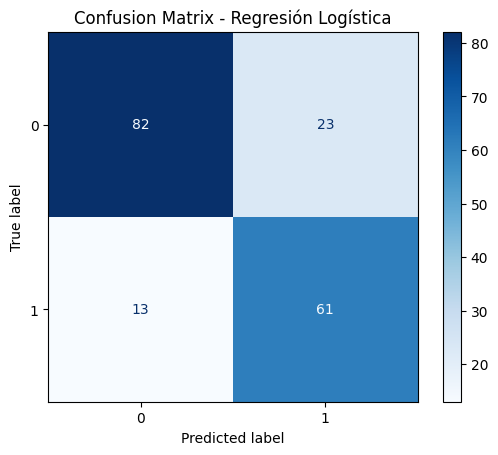

In [227]:
cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Regresión Logística")
plt.show()

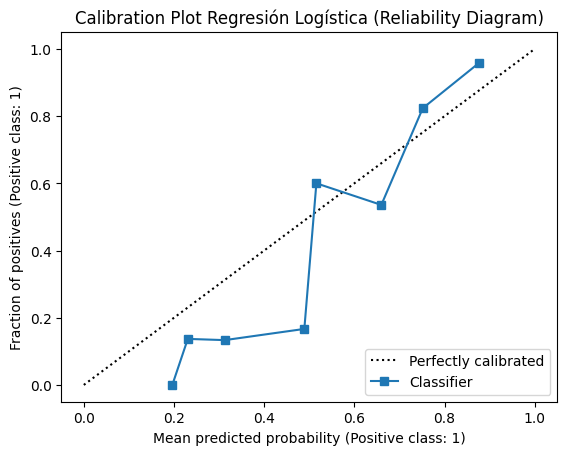

Brier Score: 0.152916393648795
Expected Calibration Error (ECE): 0.10936488135377578


In [228]:
disp = CalibrationDisplay.from_predictions(
    Y_test, y_proba, n_bins=10, strategy="uniform")
plt.title("Calibration Plot Regresión Logística (Reliability Diagram)")
plt.show()

from sklearn.metrics import brier_score_loss

brier = brier_score_loss(Y_test, y_proba)
print("Brier Score:", brier)

def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins+1)
    binids = np.digitize(y_prob, bins) - 1

    ece = 0.0
    for i in range(n_bins):
        mask = binids == i
        if np.any(mask):
            avg_conf = y_prob[mask].mean()
            avg_acc  = y_true[mask].mean()
            ece += np.abs(avg_conf - avg_acc) * len(y_prob[mask]) / len(y_prob)
    return ece

ece = expected_calibration_error(Y_test.values, y_proba, n_bins=10)
print("Expected Calibration Error (ECE):", ece)

## Random Forest

Hallamos los mejores hiperparámetros:

In [229]:
n_estimators = [100, 200, 300, 500]
max_depth = [3, 5, 7, 10, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_features = ['sqrt', 'log2', 0.3, 0.5]

# def hyperparametros(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
#     best_accuracy = 0
#     for n in n_estimators:
#         for md in max_depth:
#             for mss in min_samples_split:
#                 for msl in min_samples_leaf:
#                     for mf in max_features:
#                         try:
#                             model = RandomForestClassifier(
#                                 n_estimators=n,
#                                 max_depth=md,
#                                 min_samples_split=mss,
#                                 min_samples_leaf=msl,
#                                 max_features=mf,
#                                 random_state=42)
#                             model.fit(X_train, Y_train)
#                             y_pred = model.predict(X_test)
#                             accuracy = accuracy_score(Y_test, y_pred)
#                             if accuracy > best_accuracy:
#                                 best_accuracy = accuracy
#                                 best_params = [n, md, mss, msl, mf]
#                         except:
#                             continue
#     return best_accuracy, best_params
# hyperparametros(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features)

In [230]:
b_p = [100, 7, 2, 2, 'sqrt']

model = RandomForestClassifier(
    n_estimators=b_p[0],
    max_depth=b_p[1],
    min_samples_split=b_p[2],
    min_samples_leaf=b_p[3],
    max_features=b_p[4],
    random_state=42)

start_train = time.time()
model.fit(X_train, Y_train)
end_train = time.time()

start_infer = time.time()
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1] 
end_infer = time.time()

fpr, tpr, thresholds = roc_curve(Y_test, y_proba)
roc_auc = ((fpr,tpr) , auc(fpr, tpr))
AUC.append(roc_auc)

print("Accuracy:", accuracy_score(Y_test, y_pred))
print("\nReporte de Clasificación:\n", classification_report(Y_test, y_pred))

Accuracy: 0.8044692737430168

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       105
           1       0.79      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



Feature importance (Gini y permutation)

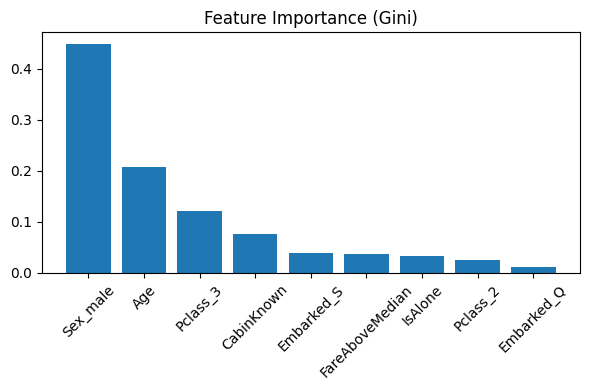

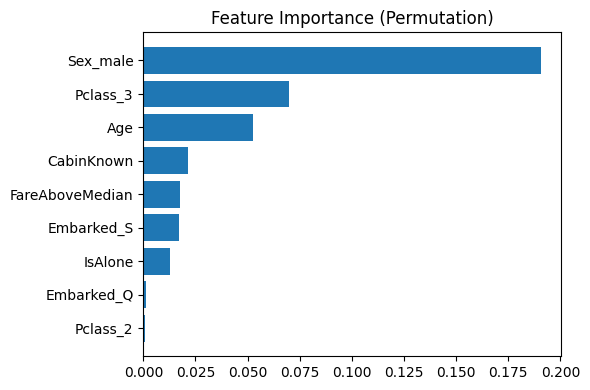

In [231]:
# Gini importance (impureza)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(6,4))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.title("Feature Importance (Gini)")
plt.tight_layout()
plt.show()

# Permutation importance
perm_importance = permutation_importance(model, X_train, Y_train, n_repeats=30, random_state=42, n_jobs=-1)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(6,4))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), X_train.columns[sorted_idx])
plt.title("Feature Importance (Permutation)")
plt.tight_layout()
plt.show()

Análisis de profundidad efectiva de árboles

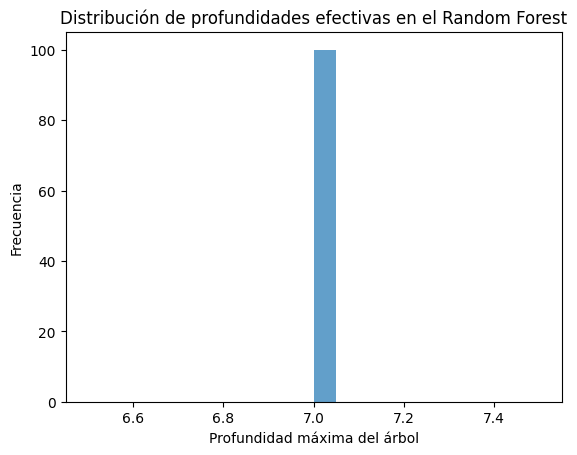

Profundidad media: 7.00, máx: 7, mín: 7


In [232]:
tree_depths = [estimator.tree_.max_depth for estimator in model.estimators_]

plt.hist(tree_depths, bins=20, alpha=0.7)
plt.xlabel("Profundidad máxima del árbol")
plt.ylabel("Frecuencia")
plt.title("Distribución de profundidades efectivas en el Random Forest")
plt.show()

print(f"Profundidad media: {np.mean(tree_depths):.2f}, máx: {np.max(tree_depths)}, mín: {np.min(tree_depths)}")

OOB score evolution

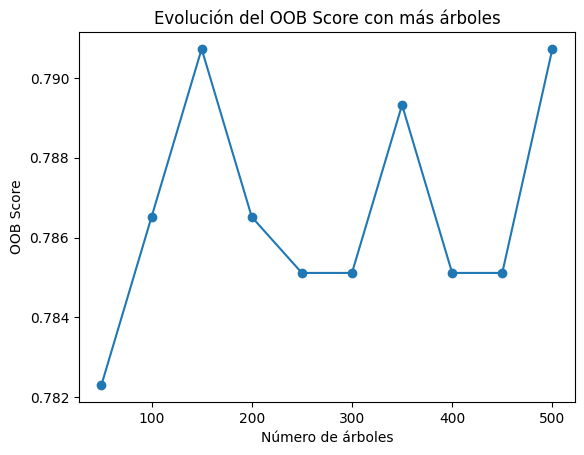

In [233]:
oob_scores = []
n_estimators_range = range(50, 501, 50)

for n in n_estimators_range:
    rf_temp = RandomForestClassifier(
        n_estimators=n,
        max_depth=None,
        min_samples_split=b_p[2],
        min_samples_leaf=b_p[3],
        max_features=b_p[4],
        oob_score=True,
        random_state=42,
        n_jobs=-1)
    rf_temp.fit(X_train, Y_train)
    oob_scores.append(rf_temp.oob_score_)

plt.plot(n_estimators_range, oob_scores, marker="o")
plt.xlabel("Número de árboles")
plt.ylabel("OOB Score")
plt.title("Evolución del OOB Score con más árboles")
plt.show()

Estabilidad de importancias con diferentes seeds

                Age  Pclass_2  Pclass_3  Sex_male  CabinKnown  \
seed 0     0.311691  0.025613  0.093636  0.388779    0.067372   
seed 42    0.309522  0.026203  0.095351  0.388583    0.068787   
seed 100   0.304539  0.025852  0.094065  0.392883    0.071035   
seed 2025  0.312677  0.024904  0.096409  0.389962    0.064496   

           FareAboveMedian  Embarked_Q  Embarked_S   IsAlone  
seed 0            0.035972    0.010935    0.034882  0.031119  
seed 42           0.035671    0.011895    0.034179  0.029809  
seed 100          0.036581    0.010906    0.033902  0.030236  
seed 2025         0.037619    0.011241    0.032441  0.030252  


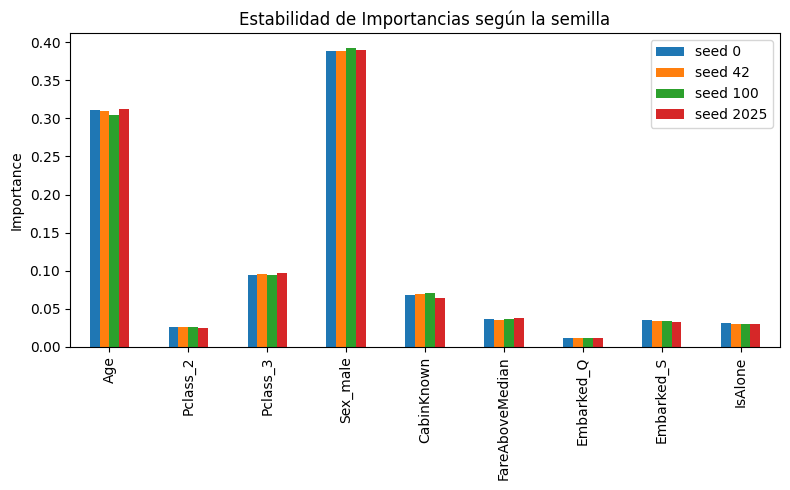

In [234]:
seeds = [0, 42, 100, 2025]
importancias = []

for seed in seeds:
    rf_temp = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=b_p[2],
        min_samples_leaf=b_p[3],
        max_features=b_p[4],
        random_state=seed,
        n_jobs=-1)
    rf_temp.fit(X_train, Y_train)
    importancias.append(rf_temp.feature_importances_)

df_importancias = pd.DataFrame(importancias, columns=X_train.columns, index=[f"seed {s}" for s in seeds])
print(df_importancias)

df_importancias.T.plot(kind="bar", figsize=(8,5))
plt.title("Estabilidad de Importancias según la semilla")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### Evaulación y Comparación

In [235]:
# Métricas básicas
accuracy  = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall    = recall_score(Y_test, y_pred)
f1        = f1_score(Y_test, y_pred)

roc_auc   = roc_auc_score(Y_test, y_proba)
pr_auc    = average_precision_score(Y_test, y_proba)
mcc       = matthews_corrcoef(Y_test, y_pred)
bal_acc   = balanced_accuracy_score(Y_test, y_pred)

metrics = {
    "Modelo": "Random Forest",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1": f1,
    "ROC-AUC": roc_auc,
    "Tiempo Training": end_train - start_train,
    "Tiempo Inference": end_infer - start_infer
}
results_df = pd.DataFrame([metrics])
df_metrics = pd.concat([df_metrics, results_df])

print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-Score:  {f1:.3f}")
print(f"ROC-AUC:   {roc_auc:.3f}")
print(f"PR-AUC:    {pr_auc:.3f}")
print(f"MCC:       {mcc:.3f}")
print(f"Balanced Accuracy: {bal_acc:.3f}")

Accuracy:  0.804
Precision: 0.791
Recall:    0.716
F1-Score:  0.752
ROC-AUC:   0.881
PR-AUC:    0.853
MCC:       0.593
Balanced Accuracy: 0.791


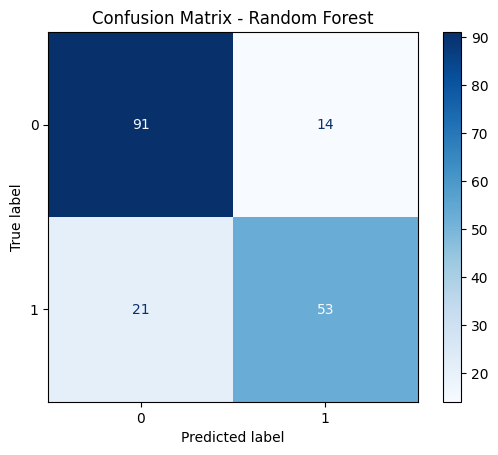

In [236]:
cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()

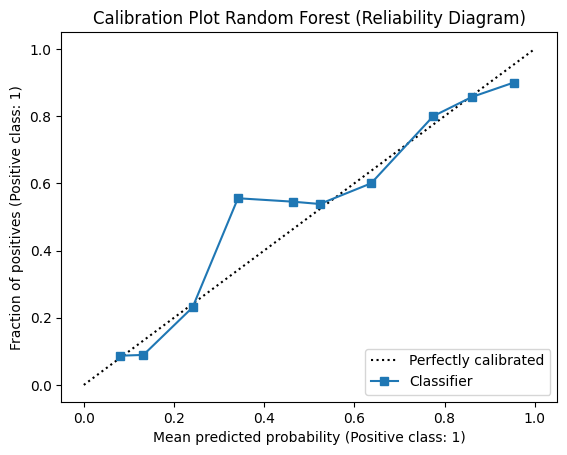

Brier Score: 0.13114024753543524
Expected Calibration Error (ECE): 0.042986139424797155


In [237]:
disp = CalibrationDisplay.from_predictions(
    Y_test, y_proba, n_bins=10, strategy="uniform")
plt.title("Calibration Plot Random Forest (Reliability Diagram)")
plt.show()

from sklearn.metrics import brier_score_loss

brier = brier_score_loss(Y_test, y_proba)
print("Brier Score:", brier)

def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins+1)
    binids = np.digitize(y_prob, bins) - 1

    ece = 0.0
    for i in range(n_bins):
        mask = binids == i
        if np.any(mask):
            avg_conf = y_prob[mask].mean()
            avg_acc  = y_true[mask].mean()
            ece += np.abs(avg_conf - avg_acc) * len(y_prob[mask]) / len(y_prob)
    return ece

ece = expected_calibration_error(Y_test.values, y_proba, n_bins=10)
print("Expected Calibration Error (ECE):", ece)

## Neural Network


In [238]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp = MLPClassifier(
    hidden_layer_sizes=(50, 25),
    activation='relu',
    solver='adam',
    alpha=0.001,
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    n_iter_no_change=20,
    validation_fraction=0.2)

start_train = time.time()
mlp.fit(X_train_scaled, Y_train)
end_train = time.time()

start_infer = time.time()
y_pred = mlp.predict(X_test_scaled)
y_proba = mlp.predict_proba(X_test_scaled)[:, 1]
end_infer = time.time()

fpr, tpr, thresholds = roc_curve(Y_test, y_proba)
roc_auc = ((fpr,tpr) , auc(fpr, tpr))
AUC.append(roc_auc)

print("Accuracy:", accuracy_score(Y_test, y_pred))
print("Classification Report:\n", classification_report(Y_test, y_pred))

Accuracy: 0.8268156424581006
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86       105
           1       0.84      0.72      0.77        74

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.82       179



Curva ROC

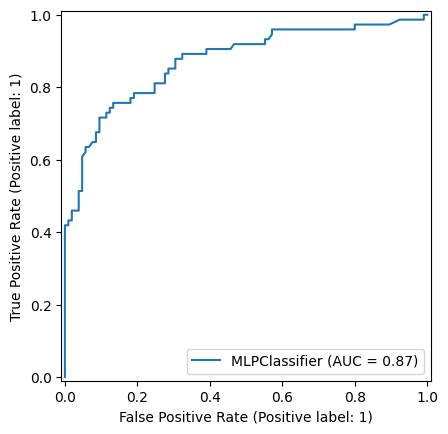

In [239]:
RocCurveDisplay.from_estimator(mlp, X_test_scaled, Y_test)
plt.show()

Loss curve (curva de aprendizaje)

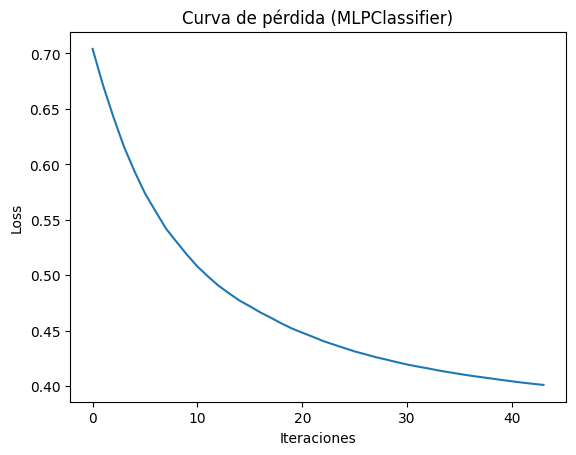

In [240]:
plt.plot(mlp.loss_curve_)
plt.title("Curva de pérdida (MLPClassifier)")
plt.xlabel("Iteraciones")
plt.ylabel("Loss")
plt.show()

### Evaulación y Comparación

In [241]:
# Métricas básicas
accuracy  = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall    = recall_score(Y_test, y_pred)
f1        = f1_score(Y_test, y_pred)

roc_auc   = roc_auc_score(Y_test, y_proba)
pr_auc    = average_precision_score(Y_test, y_proba)
mcc       = matthews_corrcoef(Y_test, y_pred)
bal_acc   = balanced_accuracy_score(Y_test, y_pred)

metrics = {
    "Modelo": "Neural Network",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1": f1,
    "ROC-AUC": roc_auc,
    "Tiempo Training": end_train - start_train,
    "Tiempo Inference": end_infer - start_infer
}
results_df = pd.DataFrame([metrics])
df_metrics = pd.concat([df_metrics, results_df])

print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-Score:  {f1:.3f}")
print(f"ROC-AUC:   {roc_auc:.3f}")
print(f"PR-AUC:    {pr_auc:.3f}")
print(f"MCC:       {mcc:.3f}")
print(f"Balanced Accuracy: {bal_acc:.3f}")

Accuracy:  0.827
Precision: 0.841
Recall:    0.716
F1-Score:  0.774
ROC-AUC:   0.873
PR-AUC:    0.865
MCC:       0.640
Balanced Accuracy: 0.810


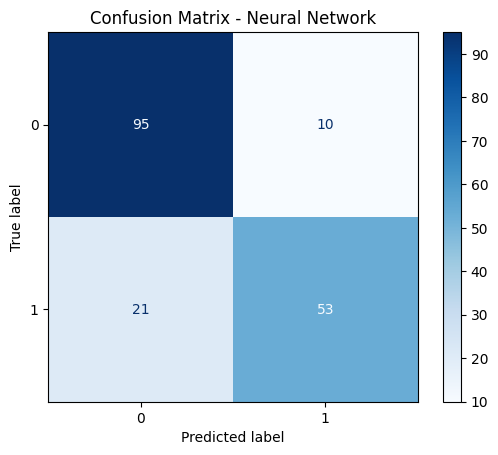

In [242]:
cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Neural Network")
plt.show()

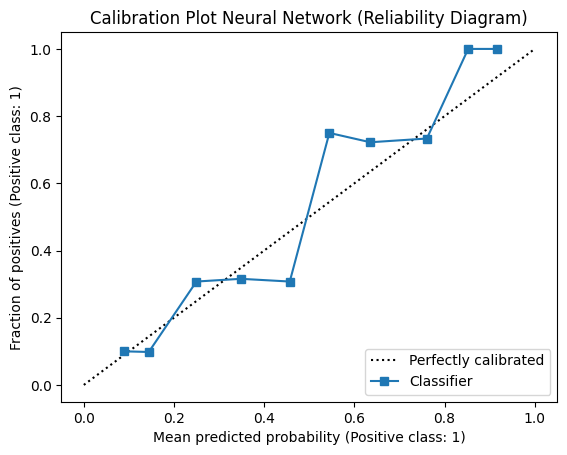

Brier Score: 0.1378702179029259
Expected Calibration Error (ECE): 0.06730287634325112


In [243]:
disp = CalibrationDisplay.from_predictions(
    Y_test, y_proba, n_bins=10, strategy="uniform")
plt.title("Calibration Plot Neural Network (Reliability Diagram)")
plt.show()

from sklearn.metrics import brier_score_loss

brier = brier_score_loss(Y_test, y_proba)
print("Brier Score:", brier)

def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins+1)
    binids = np.digitize(y_prob, bins) - 1

    ece = 0.0
    for i in range(n_bins):
        mask = binids == i
        if np.any(mask):
            avg_conf = y_prob[mask].mean()
            avg_acc  = y_true[mask].mean()
            ece += np.abs(avg_conf - avg_acc) * len(y_prob[mask]) / len(y_prob)
    return ece

ece = expected_calibration_error(Y_test.values, y_proba, n_bins=10)
print("Expected Calibration Error (ECE):", ece)

## Support Vector Machine

TitanicSVMAnalyzer inicializado correctamente
Dataset shape: (891, 10)
Preparando características para el modelo...
Características preparadas correctamente
   Features: ['Age', 'Pclass_2', 'Pclass_3', 'Sex_male', 'CabinKnown', 'FareAboveMedian', 'Embarked_Q', 'Embarked_S', 'IsAlone']
   Varianza explicada PCA: [0.26715575 0.18977924]
   Target distribution: {0: 549, 1: 342}
Iniciando entrenamiento del modelo SVM...
Ejecutando RandomizedSearchCV...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

RESULTADOS DEL MODELO SVM
Mejores parámetros: {'kernel': 'rbf', 'gamma': 0.1, 'C': 0.1}
Mejor score CV: 0.8062
Score test: 0.8045
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.78      0.95      0.86       110
           1       0.89      0.57      0.69        69

    accuracy                           0.80       179
   macro avg       0.83      0.76      0.77       179
weighted avg       0.82      0.80      0.79       179

En

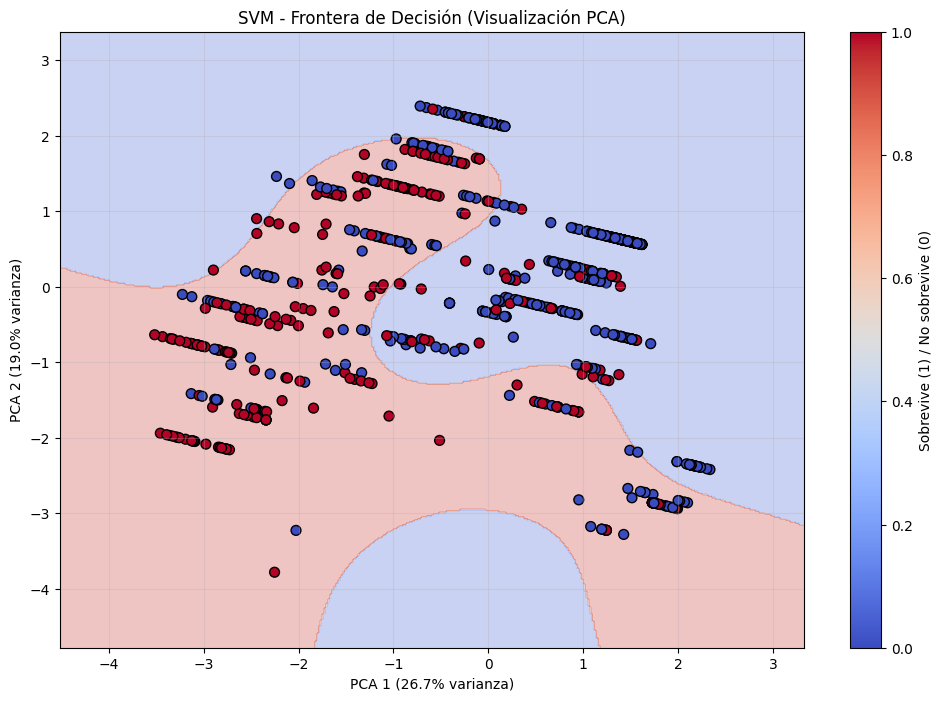

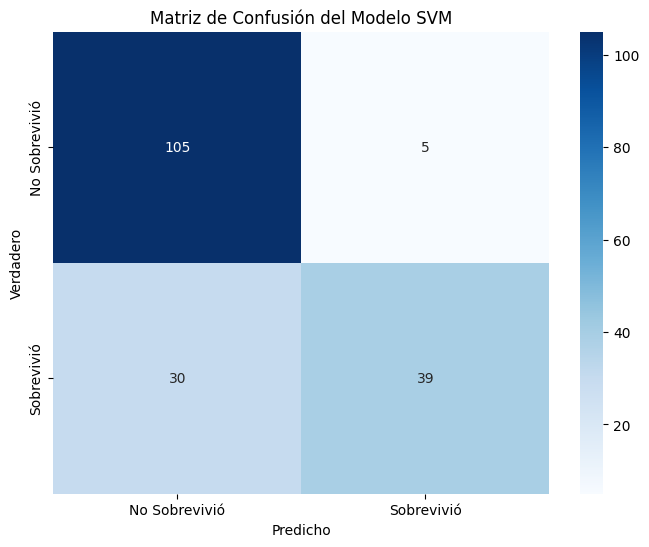

RESUMEN DEL MODELO ENTRENADO
kernel              : rbf
C                   : 0.1
gamma               : 0.1
n_support_vectors   : 463
feature_columns     : ['Age', 'Pclass_2', 'Pclass_3', 'Sex_male', 'CabinKnown', 'FareAboveMedian', 'Embarked_Q', 'Embarked_S', 'IsAlone']
dataset_size        : 891 muestras, 9 características
MÉTRICAS DEL MODELO (Cross-Validation)


,Score
Accuracy,0.803
Precision,0.869
Recall,0.575
F1-Score,0.689
ROC-AUC,NaN
Balanced Acc.,0.760


In [244]:
class TitanicSVMAnalyzer:
    def __init__(self, df):
        """
        Inicializa el analizador con DataFrame ya procesado
        """
        self.df = df.copy()
        self.X = None
        self.y = None
        self.X_scaled = None
        self.X_pca = None
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=2)
        self.best_model = None
        self.visual_model = None
        # self.start_train = None
        # self.end_train = None
        # self.start_infer = None
        # self.end_infer = None
        
        print("TitanicSVMAnalyzer inicializado correctamente")
        print(f"Dataset shape: {self.df.shape}")

    def prepare_features(self):
        """Prepara características y target (asume datos ya procesados)"""
        print("Preparando características para el modelo...")
        
        # Separar características y target
        self.X = self.df.drop('Survived', axis=1).copy()
        self.y = self.df['Survived'].copy()
        
        # Escalar características (importante para SVM)
        self.X_scaled = self.scaler.fit_transform(self.X)
        
        # Reducción dimensional para visualización
        self.X_pca = self.pca.fit_transform(self.X_scaled)
        
        print("Características preparadas correctamente")
        print(f"   Features: {list(self.X.columns)}")
        print(f"   Varianza explicada PCA: {self.pca.explained_variance_ratio_}")
        print(f"   Target distribution: {pd.Series(self.y).value_counts().to_dict()}")
        
        return self.X_scaled, self.y
    
    def train_full_model(self, test_size=0.2, random_state=42):
        """Entrena el modelo SVM con los datos ya procesados"""
        if self.X_scaled is None:
            self.prepare_features()
        
        print("Iniciando entrenamiento del modelo SVM...")
        
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_scaled, self.y, test_size=test_size, random_state=random_state, stratify=self.y
        )
        
        # Espacio de parámetros optimizado
        param_dist = {
            "C": [0.1, 1, 10, 100],
            "kernel": ["rbf", "linear"],
            "gamma": ["scale", 0.01, 0.1, 1]
        }
        
        svm = SVC(random_state=random_state, probability=True)
        
        random_search = RandomizedSearchCV(
            svm,
            param_distributions=param_dist,
            n_iter=12,
            cv=3,
            n_jobs=-1,
            verbose=1,
            random_state=random_state,
            scoring='accuracy'
        )
        
        print("Ejecutando RandomizedSearchCV...")
        
        #self.start_train = time.time()
        random_search.fit(X_train, y_train)
        #self.end_train = time.time()
        
        self.best_model = random_search.best_estimator_
        
        print("\n" + "="*60)
        print("RESULTADOS DEL MODELO SVM")
        print("="*60)
        
        print(f"Mejores parámetros: {random_search.best_params_}")
        print(f"Mejor score CV: {random_search.best_score_:.4f}")
        
        # Evaluación en test
        #self.start_infer = time.time()
        y_pred = self.best_model.predict(X_test)
        #self.end_infer = time.time()
        test_score = self.best_model.score(X_test, y_test)
        print(f"Score test: {test_score:.4f}")

        print("Reporte de clasificación:")
        print(classification_report(y_test, y_pred))
        
        return random_search
    
    def train_visualization_model(self):
        """Entrena modelo para visualización con PCA"""
        if self.X_pca is None:
            self.prepare_features()
        
        print("Entrenando modelo para visualización PCA...")
        self.visual_model = SVC(C=10, kernel='rbf', gamma='scale', probability=True, random_state=42)
        self.visual_model.fit(self.X_pca, self.y)
        
        print("Modelo de visualización entrenado")
        return self.visual_model
    
    def plot_decision_boundary(self):
        """Visualiza la frontera de decisión con PCA"""
        if self.visual_model is None:
            self.train_visualization_model()
        
        print("Generando gráfico de frontera de decisión...")
        
        h = .02
        x_min, x_max = self.X_pca[:, 0].min() - 1, self.X_pca[:, 0].max() + 1
        y_min, y_max = self.X_pca[:, 1].min() - 1, self.X_pca[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        Z = self.visual_model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt.figure(figsize=(12, 8))
        plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
        scatter = plt.scatter(self.X_pca[:, 0], self.X_pca[:, 1], 
                             c=self.y, edgecolors='k', cmap=plt.cm.coolwarm, s=50)
        
        plt.xlabel(f"PCA 1 ({self.pca.explained_variance_ratio_[0]*100:.1f}% varianza)")
        plt.ylabel(f"PCA 2 ({self.pca.explained_variance_ratio_[1]*100:.1f}% varianza)")
        plt.title("SVM - Frontera de Decisión (Visualización PCA)")
        plt.colorbar(scatter, label='Sobrevive (1) / No sobrevive (0)')
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def plot_confusion_matrix(self):
        """Muestra la matriz de confusión"""
        if self.best_model is None:
            print("Primero debe entrenar el modelo completo")
            return
        
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_scaled, self.y, test_size=0.2, random_state=42, stratify=self.y
        )
        
        y_pred = self.best_model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['No Sobrevivió', 'Sobrevivió'],
                   yticklabels=['No Sobrevivió', 'Sobrevivió'])
        plt.title('Matriz de Confusión del Modelo SVM')
        plt.ylabel('Verdadero')
        plt.xlabel('Predicho')
        plt.show()
    
    def get_model_summary(self):
        """Retorna un resumen del modelo entrenado"""
        if self.best_model is None:
            return "Modelo no entrenado"
        
        summary = {
            'kernel': self.best_model.kernel,
            'C': self.best_model.C,
            'gamma': getattr(self.best_model, 'gamma', 'N/A'),
            'n_support_vectors': sum(self.best_model.n_support_),
            'feature_columns': self.X.columns.tolist(),
            'dataset_size': f"{self.X.shape[0]} muestras, {self.X.shape[1]} características"
        }
        
        print("RESUMEN DEL MODELO ENTRENADO")
        print("="*40)
        for key, value in summary.items():
            print(f"{key:20}: {value}")
        
        return summary
    
    def get_metrics_table(self, n_splits=5, n_repeats=3):
        """Calcula métricas del modelo"""
        if self.best_model is None:
            print("Primero debe entrenar el modelo completo")
            return None

        cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

        scoring = {
            'Accuracy': make_scorer(accuracy_score),
            'Precision': make_scorer(precision_score),
            'Recall': make_scorer(recall_score),
            'F1-Score': make_scorer(f1_score),
            'ROC-AUC': make_scorer(roc_auc_score, needs_proba=True),
            'Balanced Acc.': make_scorer(balanced_accuracy_score),
        }

        results = {}
        for metric_name, scorer in scoring.items():
            scores = cross_val_score(self.best_model, self.X_scaled, self.y, scoring=scorer, cv=cv, n_jobs=-1)
            mean = np.mean(scores)
            results[metric_name] = mean

        df_metrics = pd.DataFrame.from_dict(results, orient='index', columns=['Score'])
        df_metrics = df_metrics.round(3)
        
        print("MÉTRICAS DEL MODELO (Cross-Validation)")
        print("="*50)
        display(df_metrics)
        
        return df_metrics

# Uso simplificado:
analyzer = TitanicSVMAnalyzer(df)
analyzer.prepare_features()
analyzer.train_full_model()
analyzer.plot_decision_boundary()
analyzer.plot_confusion_matrix()
analyzer.get_model_summary()
metrics_table = analyzer.get_metrics_table()

In [245]:
results_df = pd.DataFrame([{'Modelo': 'Support Vector Machine',
    'Accuracy': metrics_table.loc['Accuracy', 'Score'],
    'Precision': metrics_table.loc['Precision', 'Score'],
    'Recall': metrics_table.loc['Recall', 'Score'],
    'F1': metrics_table.loc['F1-Score', 'Score'],
    'ROC-AUC': metrics_table.loc['ROC-AUC', 'Score'],
    'Tiempo Training': np.nan,
    'Tiempo Inference': np.nan}])
df_metrics = pd.concat([df_metrics, results_df], ignore_index=True)

## Comparación entre modelos

In [246]:
df_metrics.round(3)

,Modelo,Accuracy,Precision,Recall,F1,ROC-AUC,Tiempo Training,Tiempo Inference
0,XGBoost,0.816,0.847,0.676,0.752,0.880,0.091,0.007
1,Regresión Logística,0.799,0.726,0.824,0.772,0.862,0.019,0.005
2,Random Forest,0.804,0.791,0.716,0.752,0.881,0.148,0.018
3,Neural Network,0.827,0.841,0.716,0.774,0.873,0.122,0.001
4,Support Vector Machine,0.803,0.869,0.575,0.689,NaN,NaN,NaN


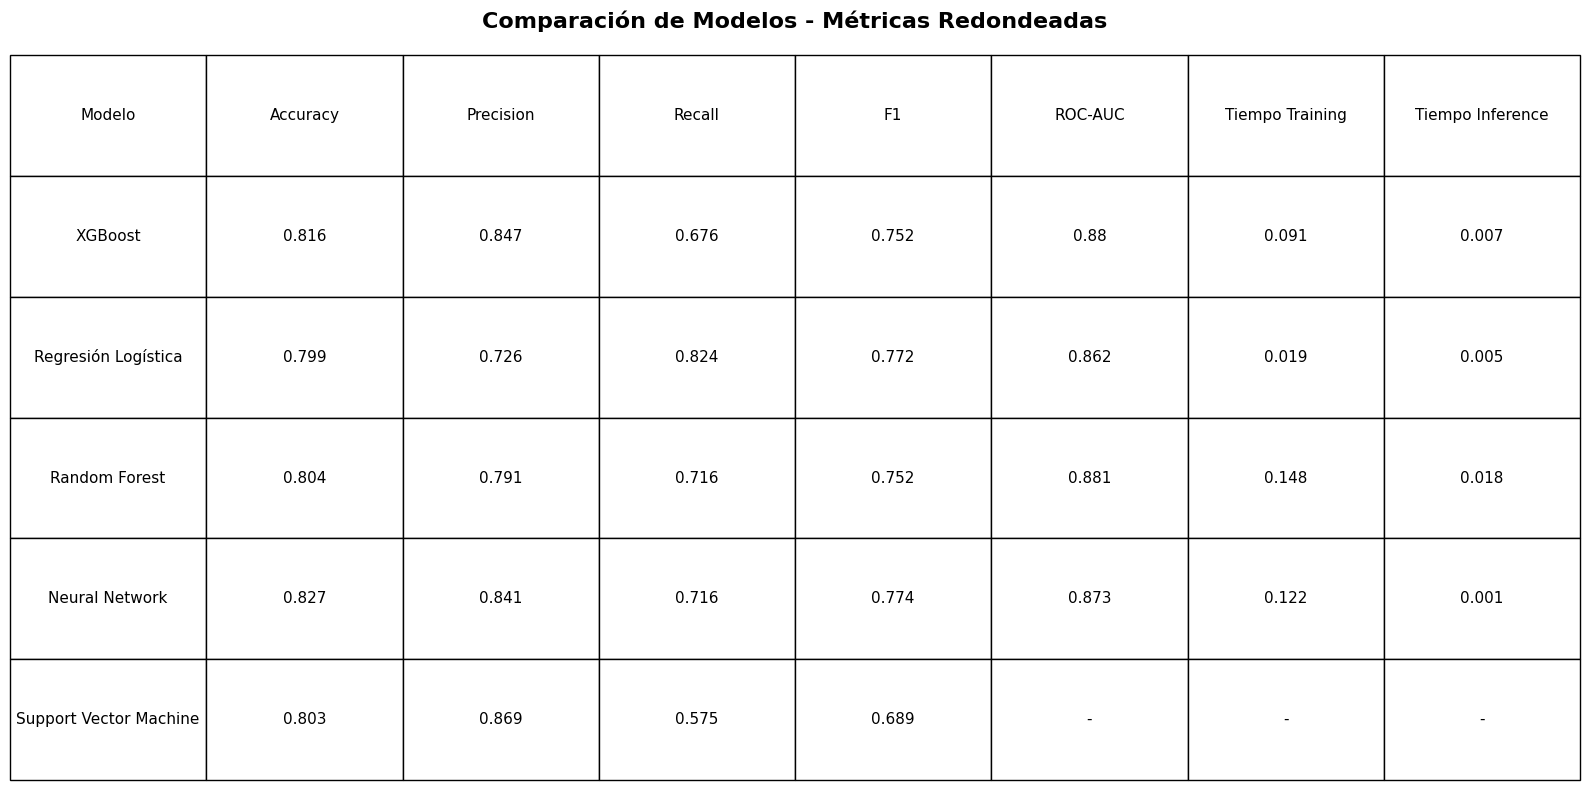

DataFrame redondeado:


,Modelo,Accuracy,Precision,Recall,F1,ROC-AUC,Tiempo Training,Tiempo Inference
0,XGBoost,0.816,0.847,0.676,0.752,0.88,0.091,0.007
1,Regresión Logística,0.799,0.726,0.824,0.772,0.862,0.019,0.005
2,Random Forest,0.804,0.791,0.716,0.752,0.881,0.148,0.018
3,Neural Network,0.827,0.841,0.716,0.774,0.873,0.122,0.001
4,Support Vector Machine,0.803,0.869,0.575,0.689,-,-,-


In [247]:
def crear_tabla_metricas_redondeada(df_metrics, nombre_archivo='metricas_modelos.png'):
    """
    Crea una imagen de la tabla de métricas con valores redondeados
    """
    # Redondear todos los valores numéricos
    df_rounded = df_metrics.copy()
    numeric_cols = df_rounded.select_dtypes(include=[np.number]).columns
    df_rounded[numeric_cols] = df_rounded[numeric_cols].round(3)
    
    # Reemplazar NaN con '-'
    df_rounded = df_rounded.fillna('-')
    
    # Crear figura
    plt.figure(figsize=(16, 8))
    ax = plt.subplot(111, frame_on=False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    # Crear tabla con valores redondeados
    table = plt.table(cellText=df_rounded.values,
                     colLabels=df_rounded.columns,
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    
    # Formatear
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 2)
    
    # Estilo
    plt.title('Comparación de Modelos - Métricas Redondeadas', 
              fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    
    # Guardar
    plt.savefig(nombre_archivo, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    return df_rounded

# Usar la función
df_redondeado = crear_tabla_metricas_redondeada(df_metrics)
print("DataFrame redondeado:")
display(df_redondeado)

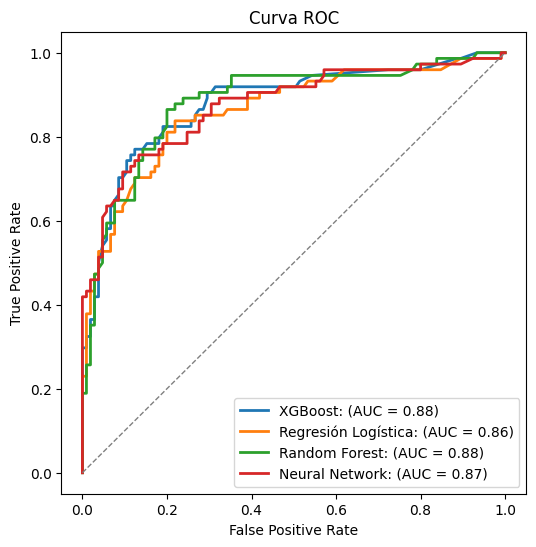

In [248]:
models_list = df_metrics['Modelo'].tolist()
models_list.pop(-1)
plt.figure(figsize=(6, 6))
for i in range(len(AUC)):
    fpr, tpr = AUC[i][0]
    roc_auc = AUC[i][1]
    plt.plot(fpr, tpr, lw=2, label=f"{models_list[i]}: (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=1)  # línea aleatoria
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()